# Story 1
Andrew Bowen    
DATA 608: Knowledge and Visual Analytics    
CUNY Data Science Master's    

## Introduction
The [Infrastructure Investment and Jobs Act](https://www.congress.gov/bill/117th-congress/house-bill/3684/text) provided over $500 billion federal funding for infrastructure projects (highway construction an droad programs) at the state level. This act was signed into law under the Biden Administration, with the goal of improving infrastructure within the United States. 

For the Biden Administration the act could potentially have the political benefit of creating jobs in states that receive federal funds. 

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import json

## Part 1
*Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?*

To measure equity of funding, we'll need to see a plot of *funding per capita per state*

In [83]:
# First, let's read our data into a pandas dataframe
df = pd.read_excel("./data/IIJA-FUNDING-AS-OF-MARCH-2023.xlsx")
df.head()

,"State, Teritory or Tribal Nation",Total (Billions)
0,ALABAMA,3.0000
1,ALASKA,3.7000
2,AMERICAN SAMOA,0.0686
3,ARIZONA,3.5000
4,ARKANSAS,2.8000


In [84]:
# Clean up our dataframe names and types
df.columns = ['state', 'total_funding']
df['total_funding'] = df['total_funding'].astype(float)

df.head()

,state,total_funding
0,ALABAMA,3.0000
1,ALASKA,3.7000
2,AMERICAN SAMOA,0.0686
3,ARIZONA,3.5000
4,ARKANSAS,2.8000


In [1]:

f, ax = plt.subplots(figsize=(12, 12))
ax.bar(df.state, df.total_funding)
ax.set_xticks(df.state.values)
ax.set_xticklabels(df.state.values, rotation=90)

ax.set_title("Total Infrastructure Investment and Jobs Act funding Funding (billions) by state/territory")
ax.set_ylabel("Total Funding (Billions $)")
ax.set_xlabel("State/Terrotory")


NameError: name 'plt' is not defined

In [86]:
# Read in GeoJSON containing state boundary data
geojson_path = "./data/us-states.json"
with open(geojson_path, "r") as f:
    states = json.load(f)

# Making our state
df['state'] = df.state.apply(str.title).apply(str.strip).astype(str)
df.head()

,state,total_funding
0,Alabama,3.0000
1,Alaska,3.7000
2,American Samoa,0.0686
3,Arizona,3.5000
4,Arkansas,2.8000


Let's make a choropleth plot first of the **total** funding for each state. We'll be using the [python `plotly` library](https://plotly.com/python/choropleth-maps/) to accomplish this.

In [87]:
# Plot a choropleth using plotly
fig = px.choropleth(df, geojson=states, locations='state', color='total_funding',
                    color_continuous_scale="Viridis",
                    range_color=(0, 12),
                    scope="usa", featureidkey='properties.name',
                    labels={'total_funding': 'Total Funding (Billions $)'},
                    title="IIJA Total State Funding")

fig.show()

## Population Data
Looking at total funding per state, there's a tendency for larger states (California, Texas, New York) to receive higher amounts of funding. We should include the population of each state, as that will give us a better sense of funding per capita. I found [state population totals from the US Census Bureau here](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html) and can join this onto our original dataframe

In [88]:
# Read in local population data
population = pd.read_excel("./data/NST-EST2022-POP.xlsx", header=3)

# Rename columns and update state values for joining
population.columns = ["state",
                      "base_population",
                      "population_estimate_2020",
                      "population_estimate_2021",
                      "population_estimate_2022"]
population["state"] = population["state"].astype(str).apply(str.title).apply(str.strip)
population["state"] = population["state"].str.replace(".", "").astype(str)

population.head(10)

/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_84681/3320595781.py:11: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,state,base_population,population_estimate_2020,population_estimate_2021,population_estimate_2022
0,United States,331449520.0,331511512.0,332031554.0,333287557.0
1,Northeast,57609156.0,57448898.0,57259257.0,57040406.0
2,Midwest,68985537.0,68961043.0,68836505.0,68787595.0
3,South,126266262.0,126450613.0,127346029.0,128716192.0
4,West,78588565.0,78650958.0,78589763.0,78743364.0
5,Alabama,5024356.0,5031362.0,5049846.0,5074296.0
6,Alaska,733378.0,732923.0,734182.0,733583.0
7,Arizona,7151507.0,7179943.0,7264877.0,7359197.0
8,Arkansas,3011555.0,3014195.0,3028122.0,3045637.0
9,California,39538245.0,39501653.0,39142991.0,39029342.0


In [89]:
# Joining population data to our funding data, and calculating funding per capita
df = df.merge(population, how="left", left_on="state", right_on="state")
df['funding_per_capita'] = df['total_funding'] * 1_000_000_000 / df['base_population']

df.head()

,state,total_funding,base_population,population_estimate_2020,population_estimate_2021,population_estimate_2022,funding_per_capita
0,Alabama,3.0000,5024356.0,5031362.0,5049846.0,5074296.0,597.091448
1,Alaska,3.7000,733378.0,732923.0,734182.0,733583.0,5045.147250
2,American Samoa,0.0686,NaN,NaN,NaN,NaN,NaN
3,Arizona,3.5000,7151507.0,7179943.0,7264877.0,7359197.0,489.407338
4,Arkansas,2.8000,3011555.0,3014195.0,3028122.0,3045637.0,929.752238


In [90]:
# Plot a choropleth using plotly
fig = px.choropleth(df, geojson=states, locations='state', color='funding_per_capita',
                    scope="usa", featureidkey='properties.name',
                    labels={'funding_per_capita': 'Funding Per Capita ($)'},
                    title="IIJA State Funding per Capita ($)")

fig.show()

Text(0.5, 0, 'State/Terrotory')

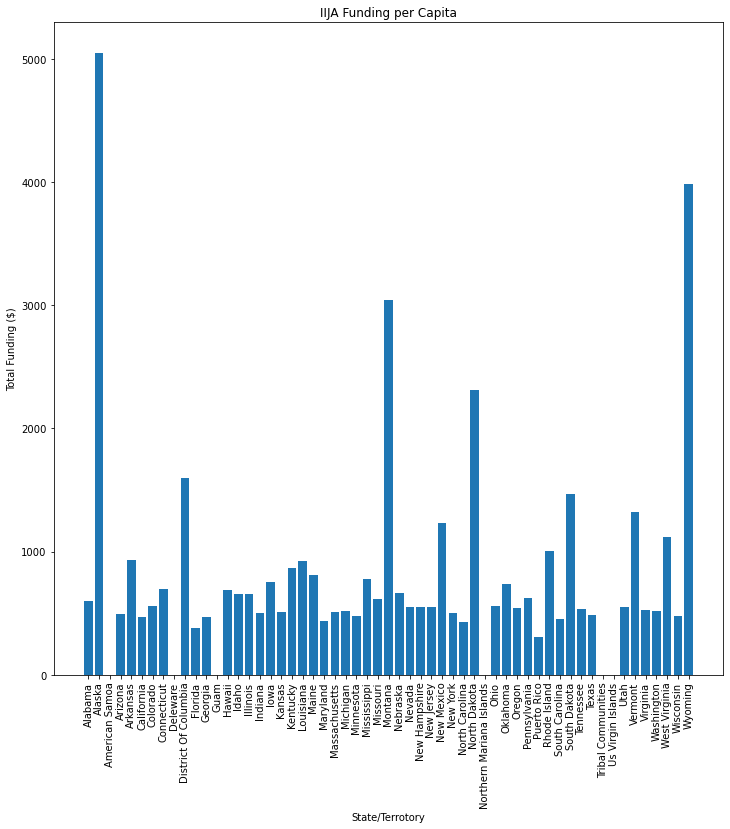

In [91]:
# Plot funding per capital )bar plot0
f, ax = plt.subplots(figsize=(12, 12))
ax.bar(df.state, df.funding_per_capita)
ax.set_xticks(df.state.values)
ax.set_xticklabels(df.state.values, rotation=90)

ax.set_title("IIJA Funding per Capita")
ax.set_ylabel("Total Funding ($)")
ax.set_xlabel("State/Terrotory")

## Part 2
*Does the allocation favor the political interests of the Biden administration?*    

There's a lot of ways to define the political interests of the Biden administration. Namely, one of their main goals is re-election in 2024. I was able to find [election data on a state level dating back to 1976 from the Harvard Dataverse project](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX). I've copied their CSV into this repository for reproducability.




In [92]:
# Read in presidential election data from 2020
election = pd.read_csv("./data/1976-2020-president.csv")
# Formatting our data so it's on a year-state level
election = election.loc[(election["party_detailed"] == "DEMOCRAT") | (election["party_detailed"] == "REPUBLICAN")]

election = election.pivot_table(values="candidatevotes", index=["year", "state"], columns="party_detailed")
election.head()

party_detailed    DEMOCRAT  REPUBLICAN
year state                            
1976 ALABAMA      659170.0    504070.0
     ALASKA        44058.0     71555.0
     ARIZONA      295602.0    418642.0
     ARKANSAS     498604.0    267903.0
     CALIFORNIA  3742284.0   3882244.0

We'll ignore parties *other* than the Democratic or Republican parties for our purposes. 

- Window our data to be at the state level
- Merge into our funding data
- Plot as choropleth for comparison to our funding per capita map above

In [93]:
election.index.get_level_values('year')

Int64Index([1976, 1976, 1976, 1976, 1976, 1976, 1976, 1976, 1976, 1976,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='year', length=612)

In [94]:
# Calculate the percent of vote per state that's for the Democratic party
election['PCT_DEMOCRATIC'] = election["DEMOCRAT"] / (election["DEMOCRAT"] + election["REPUBLICAN"])

# We only care about the 2020 election for the Biden admin
election = election.loc[election.index.get_level_values('year').isin([2020])].reset_index()
election["state"] = election.state.apply(str.title).apply(str.strip).astype(str)
election.head()

party_detailed,year,state,DEMOCRAT,REPUBLICAN,PCT_DEMOCRATIC
0,2020,Alabama,849624.0,1441170.0,0.370886
1,2020,Alaska,153778.0,189951.0,0.447382
2,2020,Arizona,1672143.0,1661686.0,0.501568
3,2020,Arkansas,423932.0,760647.0,0.357876
4,2020,California,11110250.0,6006429.0,0.649089


In [95]:
# Plot election results
fig = px.choropleth(election, geojson=states, locations='state', color='PCT_DEMOCRATIC',
                    scope="usa", featureidkey='properties.name', 
                    color_continuous_scale="RdBu",
                    range_color=(0,1),
                    labels={'PCT_DEMOCRATIC':'Percent of Vote for Democrats'},
                    title="Percent of Vote for Democratic Party - 2020 Presidential Election")

fig.show()

## Testing the Correlation Between Funding and Votes
It'd be interesting to know just **how** correlated the variables of Democratic vote percentage and per-capita funding are. We can [run a `pearsonr` test from the `scipy` python library](https://www.statology.org/correlation-test-in-python/) in order to check this correlation

In [96]:
from scipy.stats.stats import pearsonr

In [97]:
# Combine election and funding dataframes
df = df.merge(election[["state", "PCT_DEMOCRATIC"]], on="state", how="left")

df.head()

,state,total_funding,base_population,population_estimate_2020,population_estimate_2021,population_estimate_2022,funding_per_capita,PCT_DEMOCRATIC
0,Alabama,3.0000,5024356.0,5031362.0,5049846.0,5074296.0,597.091448,0.370886
1,Alaska,3.7000,733378.0,732923.0,734182.0,733583.0,5045.147250,0.447382
2,American Samoa,0.0686,NaN,NaN,NaN,NaN,NaN,NaN
3,Arizona,3.5000,7151507.0,7179943.0,7264877.0,7359197.0,489.407338,0.501568
4,Arkansas,2.8000,3011555.0,3014195.0,3028122.0,3045637.0,929.752238,0.357876


We can plot a scatter plot here to visually inspect if there's a realtionship between our variables of interest. In this case, we want to see Funding per Capita plotted against the Percent of Democratic votes in the 2020 election. We can use plotly's scatter plot function to make the visualization interactive.

In [98]:
# Plot funding per capital as a function
fig = px.scatter(df,
                 x="PCT_DEMOCRATIC", y="funding_per_capita",
                 labels={"funding_per_capita": "Funding per Capita ($)",
                         "PCT_DEMOCRATIC": "Percent of Vote for Democratic Party"},
                 hover_data=['state'],
                 title="IIJA Funding per Capita vs Percent of Democratic Vote - 2020 Election")

fig.show()

In [99]:
# Filter out nulls and get pearson coefficient
dat = df.dropna()
cor, p = pearsonr(dat["funding_per_capita"], dat["PCT_DEMOCRATIC"])

print(f"Pearson Correlation Coefficient: {cor}")
##print(f"P-Value: {p}")

Pearson Correlation Coefficient: -0.2180442861645598


## Conclusion

Overall, it looks like we have a **negative** correlation between the variables of Percent of Democratic Votes in a state vs the funding per Capita from the IIJA. This makes sense from the perspective of the Biden administration, who will likely want to inject funding into states that **didn't** vote for him, as they want to convince voters in purple (or even slightly red) states to switch their vote for the Biden administration. Infrastructre investment 


It's also possible that these states lacked critical infrastructure that *needed* improvements from the IIJA. Further analysis could include tests for existing infrastructure quality within states, and whether that variable has a relationshio with funding. In other words, did the states that needed this funding actually receive it?